In [1]:
# Step 0. Load libraries and custom functions
# Matrices and datasets ------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
# Deep Learning --------------------------------------------------------
import keras
from keras import layers
from keras.layers import TextVectorization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Custom functions -----------------------------------------------------
def sentence_fixed_split(x:list, words: int):
    """
    Split a list of sentences into a list of fixed length sentences.
    param x: sentence as a list of words
    param words: number of fixed words required
    return: list of fixed length sentences
    """
    words_lenght = len(x.split(' '))
    if words_lenght>1 and words > 1 and words_lenght > words:
        return [' '.join(x.split(' ')[i:i+words]) for i in range(0, len(x.split(' ')), words)]
    else:
        return x

In [2]:
# Step 1. Load data
# 1.1 Read csv and get basic info
df_raw = pd.read_csv('../data/01_IMDB_Dataset_HuggingFace.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [3]:
# 1.2 Get a sample
df_raw.sample(10, random_state=2024)

,review,sentiment
16441,"Like most musicals of the era, one must check ...",negative
26819,I saw this show about 3-4 years ago. It was da...,positive
9242,"One of, if not THE most visually beautiful fil...",positive
16234,Although this lovely work of art does use some...,positive
19184,Don't waste your time or money on this one. Th...,negative
34763,"Twelve Monkeys is an insane time-travelling, a...",positive
36781,Just when you thought it was safe to go back i...,negative
9082,at first i thought it was bad because i had gr...,negative
39944,"I wouldn't exactly call this a good movie, in ...",negative
38247,"This movie is very bad. In fact, the only reas...",negative


In [4]:
# 1.3 Verify if there are duplicates
df_raw['review'].duplicated().sum()

418

In [5]:
# 1.4 Preprocess data based on observed information
df_interim = df_raw.copy()
df_interim = df_interim[~df_interim.review.duplicated()]
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [6]:
# 1.5 Create the final dataframe
df_final = df_interim.copy()

In [8]:
# 1.6 Create your train, validation and test datasets
test_split = 0.3
val_split = 0.5
train_df, test_df = train_test_split(
    df_final,
    test_size=test_split,
    stratify=df_final['sentiment'].values,
    random_state=2024
)

val_df = test_df.sample(frac=val_split)
test_df = test_df.drop(val_df.index)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [9]:
# Step 2. Create a basic analysis
# 2.1 Get basic info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34707 entries, 0 to 34706
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     34707 non-null  object
 1   sentiment  34707 non-null  object
dtypes: object(2)
memory usage: 542.4+ KB


In [10]:
# 2.2 Get a summary of the data
train_df.describe(include='all')

,review,sentiment
count,34707,34707
unique,34707,2
top,The plot - in the future when nearly all men h...,positive
freq,1,17419


In [11]:
# 2.2 Get words statistics
train_df['review'].apply(lambda x: len(x.split())).describe()

count    34707.000000
mean       231.663036
std        172.210101
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
Name: review, dtype: float64

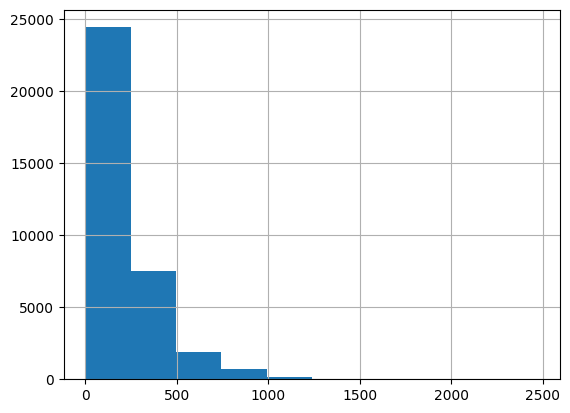

In [12]:
train_df['review'].apply(lambda x: len(x.split(' '))).hist()
plt.show()

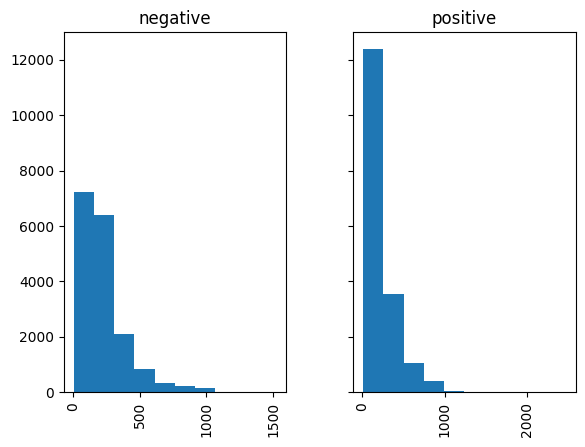

In [19]:
(train_df
 .assign(word_count = train_df['review'].apply(lambda x: len(x.split())))
 .hist('word_count', by='sentiment', grid=True, sharey=True)
)
plt.show()

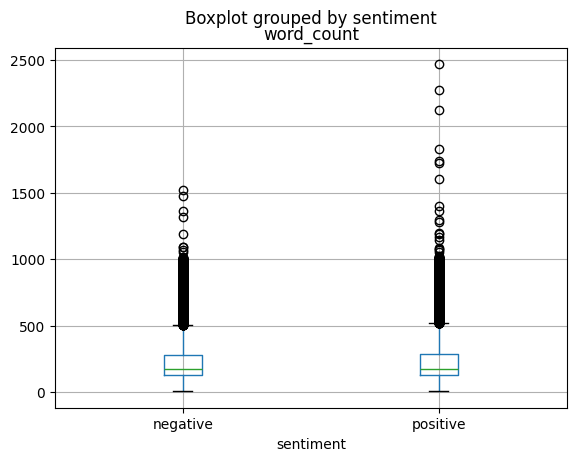

In [17]:
(train_df
 .assign(word_count = train_df['review'].apply(lambda x: len(x.split())))
 .boxplot('word_count', by='sentiment')
)
plt.show()

In [24]:
train_df['review'].str.split(expand=True).stack().value_counts()[:20]

the      395852
a        213585
and      210012
of       197593
to       182011
is       141795
in       118405
I         91558
that      88042
this      78995
it        75092
/><br     70559
was       64114
as        57623
with      57437
for       56220
The       46736
but       45908
on        42657
movie     42277
Name: count, dtype: int64

In [ ]:
df_interim.info()

In [ ]:
# 1.3 Preprocess data in order to avoid html tags and show result
df_interim = df_raw.copy()
# Get original lenght of words
df_interim['original_len'] = df_interim['review'].apply(lambda x: len(x.split(' '))) 
# Supress html tags
df_interim['user_review'] = df_interim['review'].str.replace(r'(<.*?>)','',regex=True)
# In case of many white spaces, replace with only one white space
df_interim['user_review'] = df_interim['user_review'].str.replace(r'\s+',' ',regex=True)
# In case of a space followed by a comma, replace with a comma followed by a space
df_interim['user_review'] = df_interim['user_review'].str.replace(r'\s,\s',', ',regex=True)
# Replace backslashes
df_interim['user_review'] = df_interim['user_review'].str.replace(r'\\','',regex=True)
# In case of three or more consecutive letters, replace with only two or less consecutive letters
df_interim['user_review'] = df_interim['user_review'].str.replace(r'([a-zA-Z])\1{2,}', r'\1', regex=True)
# Strip white spaces at the beginning and at the end of the review
df_interim['user_review'] = df_interim['user_review'].str.strip()
# Convert labels into integers
df_interim['label'] = df_interim['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
# Drop duplicates
df_interim = df_interim.drop_duplicates()
# There's a particular repeated row
df_interim = df_interim.drop([44855],axis=0)
# Apply custom function to split long sentences into more 
df_interim['reviews'] = df_interim['user_review'].apply(lambda x: sentence_fixed_split(x,1000))
df_interim = df_interim.explode('reviews')

In [ ]:
df = df_interim.drop(['review','sentiment','user_review'], axis=1).copy()
df

In [ ]:
# Step 3. Create a basic data analysis
# 3.1 Describe data
df.describe(include='all')

In [ ]:
# 3.2 Get statistics based on the len
df['review_len'] = df['reviews'].apply(lambda x: len(x.split(' ')))
df['review_len'].describe()

In [ ]:
# 3.3 Plot review lenght histogram
df['review_len'].hist()
plt.show()

In [ ]:
# 3.2 Preprocess text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['user_review'])
sequences = tokenizer.texts_to_sequences(df['user_review'])
X = pad_sequences(sequences, maxlen=200)

In [ ]:
# Step 4. Create model and evaluate
# 4.1 Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, df['label'], test_size=0.2, random_state=42)

In [ ]:
X_train.shape

In [ ]:
# 4.2 Build the model
imputs = keras.Input()